# Data Balancing - Stock Distribution
## Addressing Tesla Dominance

**Problem Identified in EDA:**
- TSLA: 47.1% of all tweets (29,938 tweets)
- Coefficient of Variation: 53.4% (HIGH - indicates strong stock-specific sentiment bias)

**Solution(s?):**
- Downsample high-volume stocks to maximum threshold
- Create balanced dataset for model training
- Prevent model from overfitting to Tesla-specific language patterns



## Setup & Data Loading


In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")



In [14]:
# Load merged data
merged_data = pd.read_csv('data/processed/tweets_with_stock_data.csv')

# Convert date
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

print(f"\nDataset shape: {merged_data.shape}")
print(f"Date range: {merged_data['Date'].min()} to {merged_data['Date'].max()}")
print(f"Unique stocks: {merged_data['Stock Name'].nunique()}")
print(f"\nColumns: {list(merged_data.columns)}")



Dataset shape: (63497, 11)
Date range: 2021-10-01 00:01:52+00:00 to 2022-09-29 23:41:16+00:00
Unique stocks: 25

Columns: ['Date', 'cleaned_tweet', 'Stock Name', 'Company Name', 'Open', 'High', 'Low', 'Close', 'Volume', 'daily_return', 'price_range']


## 1. Current Distribution Analysis (Before Balancing)


In [15]:
# Analyze current stock distribution
stock_counts_before = merged_data['Stock Name'].value_counts()

print("📊 CURRENT STOCK DISTRIBUTION (BEFORE BALANCING):")
print("="*70)
print(f"\nTotal tweets: {len(merged_data):,}")
print(f"\nTop 10 stocks:")
for i, (stock, count) in enumerate(stock_counts_before.head(10).items(), 1):
    pct = (count / len(merged_data)) * 100
    print(f"{i:2d}. {stock:<6} {count:>6,} tweets ({pct:5.1f}%)")

print(f"\nStatistics:")
print(f"  Mean:   {stock_counts_before.mean():,.0f} tweets per stock")
print(f"  Median: {stock_counts_before.median():,.0f} tweets per stock")
print(f"  Min:    {stock_counts_before.min():,} tweets")
print(f"  Max:    {stock_counts_before.max():,} tweets")
print(f"  Std:    {stock_counts_before.std():,.0f}")

# Calculate concentration
tsla_pct = (stock_counts_before['TSLA'] / len(merged_data)) * 100
top5_pct = (stock_counts_before.head(5).sum() / len(merged_data)) * 100

print(f"\nConcentration:")
print(f"  TSLA alone:    {tsla_pct:.1f}%")
print(f"  Top 5 stocks:  {top5_pct:.1f}%")
print(f"  Ratio (max/median): {stock_counts_before.max() / stock_counts_before.median():.1f}x")
print("="*70)


📊 CURRENT STOCK DISTRIBUTION (BEFORE BALANCING):

Total tweets: 63,497

Top 10 stocks:
 1. TSLA   29,938 tweets ( 47.1%)
 2. TSM     7,528 tweets ( 11.9%)
 3. AAPL    4,124 tweets (  6.5%)
 4. PG      3,335 tweets (  5.3%)
 5. AMZN    3,335 tweets (  5.3%)
 6. MSFT    3,335 tweets (  5.3%)
 7. META    2,314 tweets (  3.6%)
 8. NIO     2,275 tweets (  3.6%)
 9. AMD     1,790 tweets (  2.8%)
10. NFLX    1,459 tweets (  2.3%)

Statistics:
  Mean:   2,540 tweets per stock
  Median: 515 tweets per stock
  Min:    26 tweets
  Max:    29,938 tweets
  Std:    5,987

Concentration:
  TSLA alone:    47.1%
  Top 5 stocks:  76.0%
  Ratio (max/median): 58.1x


## 2. Downsampling Strategy Implementation


In [16]:
# Downsampling parameters
MAX_TWEETS_PER_STOCK = 5000  # Cap each stock at this maximum

print("⚙️ DOWNSAMPLING CONFIGURATION:")
print("="*70)
print(f"Maximum tweets per stock: {MAX_TWEETS_PER_STOCK:,}")
print(f"\nStocks that will be downsampled:")

# Identify stocks that exceed threshold
stocks_to_downsample = stock_counts_before[stock_counts_before > MAX_TWEETS_PER_STOCK]
print(f"  {len(stocks_to_downsample)} stocks exceed threshold:")
for stock, count in stocks_to_downsample.items():
    reduction = count - MAX_TWEETS_PER_STOCK
    pct_loss = (reduction / count) * 100
    print(f"    {stock}: {count:,} → {MAX_TWEETS_PER_STOCK:,} (lose {reduction:,} tweets, {pct_loss:.1f}%)")

print(f"\nStocks unchanged:")
stocks_unchanged = stock_counts_before[stock_counts_before <= MAX_TWEETS_PER_STOCK]
print(f"  {len(stocks_unchanged)} stocks remain as-is")



⚙️ DOWNSAMPLING CONFIGURATION:
Maximum tweets per stock: 5,000

Stocks that will be downsampled:
  2 stocks exceed threshold:
    TSLA: 29,938 → 5,000 (lose 24,938 tweets, 83.3%)
    TSM: 7,528 → 5,000 (lose 2,528 tweets, 33.6%)

Stocks unchanged:
  23 stocks remain as-is


In [19]:
# Perform downsampling

balanced_data = []

for stock in merged_data['Stock Name'].unique():
    stock_data = merged_data[merged_data['Stock Name'] == stock].copy()
    original_count = len(stock_data)
    
    if original_count > MAX_TWEETS_PER_STOCK:
        # Downsample with random sampling (stratified by date to keep temporal distribution)
        stock_data = stock_data.sample(n=MAX_TWEETS_PER_STOCK, random_state=42)
        print(f"  {stock}: {original_count:>6,} → {MAX_TWEETS_PER_STOCK:>6,} tweets")
    else:
        print(f"  {stock}: {original_count:>6,} tweets (unchanged)")
    
    balanced_data.append(stock_data)

# Concatenate all balanced stock data
balanced_df = pd.concat(balanced_data, ignore_index=True)


print(f"Total tweets: {len(merged_data):,} → {len(balanced_df):,}")
print(f"Data retained: {len(balanced_df)/len(merged_data)*100:.1f}%")
print(f"Data reduced by: {(1 - len(balanced_df)/len(merged_data))*100:.1f}%")


  TSLA: 29,938 →  5,000 tweets
  MSFT:  3,335 tweets (unchanged)
  PG:  3,335 tweets (unchanged)
  META:  2,314 tweets (unchanged)
  AMZN:  3,335 tweets (unchanged)
  GOOG:  1,051 tweets (unchanged)
  AMD:  1,790 tweets (unchanged)
  AAPL:  4,124 tweets (unchanged)
  NFLX:  1,459 tweets (unchanged)
  TSM:  7,528 →  5,000 tweets
  KO:    210 tweets (unchanged)
  F:     26 tweets (unchanged)
  COST:    280 tweets (unchanged)
  DIS:    515 tweets (unchanged)
  VZ:     82 tweets (unchanged)
  CRM:    173 tweets (unchanged)
  INTC:    248 tweets (unchanged)
  BA:    277 tweets (unchanged)
  BX:     33 tweets (unchanged)
  NOC:     26 tweets (unchanged)
  PYPL:    681 tweets (unchanged)
  ENPH:    150 tweets (unchanged)
  NIO:  2,275 tweets (unchanged)
  ZS:    143 tweets (unchanged)
  XPEV:    169 tweets (unchanged)
Total tweets: 63,497 → 36,031
Data retained: 56.7%
Data reduced by: 43.3%


## 3. Verification & Comparison (After Balancing)


In [22]:
# Analyze balanced distribution
stock_counts_after = balanced_df['Stock Name'].value_counts()

print(f"\nTotal tweets: {len(balanced_df):,}")
print(f"\nTop 10 stocks:")
for i, (stock, count) in enumerate(stock_counts_after.head(10).items(), 1):
    pct = (count / len(balanced_df)) * 100
    print(f"{i:2d}. {stock:<6} {count:>6,} tweets ({pct:5.1f}%)")

print(f"\nStatistics:")
print(f"  Mean:   {stock_counts_after.mean():,.0f} tweets per stock")
print(f"  Median: {stock_counts_after.median():,.0f} tweets per stock")
print(f"  Min:    {stock_counts_after.min():,} tweets")
print(f"  Max:    {stock_counts_after.max():,} tweets")
print(f"  Std:    {stock_counts_after.std():,.0f}")

# Calculate new concentration
tsla_pct_after = (stock_counts_after['TSLA'] / len(balanced_df)) * 100
top5_pct_after = (stock_counts_after.head(5).sum() / len(balanced_df)) * 100

print(f"\nConcentration:")
print(f"  TSLA alone:    {tsla_pct_after:.1f}%")
print(f"  Top 5 stocks:  {top5_pct_after:.1f}%")
print(f"  Ratio (max/median): {stock_counts_after.max() / stock_counts_after.median():.1f}x")



Total tweets: 36,031

Top 10 stocks:
 1. TSLA    5,000 tweets ( 13.9%)
 2. TSM     5,000 tweets ( 13.9%)
 3. AAPL    4,124 tweets ( 11.4%)
 4. PG      3,335 tweets (  9.3%)
 5. AMZN    3,335 tweets (  9.3%)
 6. MSFT    3,335 tweets (  9.3%)
 7. META    2,314 tweets (  6.4%)
 8. NIO     2,275 tweets (  6.3%)
 9. AMD     1,790 tweets (  5.0%)
10. NFLX    1,459 tweets (  4.0%)

Statistics:
  Mean:   1,441 tweets per stock
  Median: 515 tweets per stock
  Min:    26 tweets
  Max:    5,000 tweets
  Std:    1,665

Concentration:
  TSLA alone:    13.9%
  Top 5 stocks:  57.7%
  Ratio (max/median): 9.7x


In [25]:
# Before vs After Comparison

print(f"\n{'Metric':<30} {'BEFORE':<15} {'AFTER':<15} {'Change':<15}")
print("-"*70)

print(f"{'Total tweets':<30} {len(merged_data):<15,} {len(balanced_df):<15,} {len(balanced_df)-len(merged_data):+,}")
print(f"{'Unique stocks':<30} {merged_data['Stock Name'].nunique():<15} {balanced_df['Stock Name'].nunique():<15} {balanced_df['Stock Name'].nunique()-merged_data['Stock Name'].nunique():+}")
print(f"{'Mean per stock':<30} {stock_counts_before.mean():<15,.0f} {stock_counts_after.mean():<15,.0f} {stock_counts_after.mean()-stock_counts_before.mean():+,.0f}")
print(f"{'Median per stock':<30} {stock_counts_before.median():<15,.0f} {stock_counts_after.median():<15,.0f} {stock_counts_after.median()-stock_counts_before.median():+,.0f}")
print(f"{'Std deviation':<30} {stock_counts_before.std():<15,.0f} {stock_counts_after.std():<15,.0f} {stock_counts_after.std()-stock_counts_before.std():+,.0f}")
print(f"{'Max per stock':<30} {stock_counts_before.max():<15,} {stock_counts_after.max():<15,} {stock_counts_after.max()-stock_counts_before.max():+,}")

print(f"\n{'TSLA percentage':<30} {tsla_pct:<15.1f}% {tsla_pct_after:<15.1f}% {tsla_pct_after-tsla_pct:+.1f}%")
print(f"{'Top 5 percentage':<30} {top5_pct:<15.1f}% {top5_pct_after:<15.1f}% {top5_pct_after-top5_pct:+.1f}%")
print(f"{'Max/Median ratio':<30} {stock_counts_before.max() / stock_counts_before.median():<15.1f}x {stock_counts_after.max() / stock_counts_after.median():<15.1f}x {(stock_counts_after.max() / stock_counts_after.median()) - (stock_counts_before.max() / stock_counts_before.median()):+.1f}x")



# Assessment

if tsla_pct_after < 15:
    print("   EXCELLENT: TSLA representation is well-balanced")
elif tsla_pct_after < 20:
    print("   GOOD: TSLA representation is acceptable")
elif tsla_pct_after < 30:
    print("   MODERATE: TSLA still somewhat overrepresented")
else:
    print("   WARNING: TSLA still heavily overrepresented")

if stock_counts_after.std() < stock_counts_before.std() * 0.5:
    print("   EXCELLENT: Standard deviation greatly reduced")
elif stock_counts_after.std() < stock_counts_before.std():
    print("   GOOD: Standard deviation reduced")
else:
    print("   WARNING: No improvement in standard deviation")

print(f"\n   Overall data retention: {len(balanced_df)/len(merged_data)*100:.1f}%")



Metric                         BEFORE          AFTER           Change         
----------------------------------------------------------------------
Total tweets                   63,497          36,031          -27,466
Unique stocks                  25              25              +0
Mean per stock                 2,540           1,441           -1,099
Median per stock               515             515             +0
Std deviation                  5,987           1,665           -4,322
Max per stock                  29,938          5,000           -24,938

TSLA percentage                47.1           % 13.9           % -33.3%
Top 5 percentage               76.0           % 57.7           % -18.3%
Max/Median ratio               58.1           x 9.7            x -48.4x
   EXCELLENT: TSLA representation is well-balanced
   EXCELLENT: Standard deviation greatly reduced

   Overall data retention: 56.7%


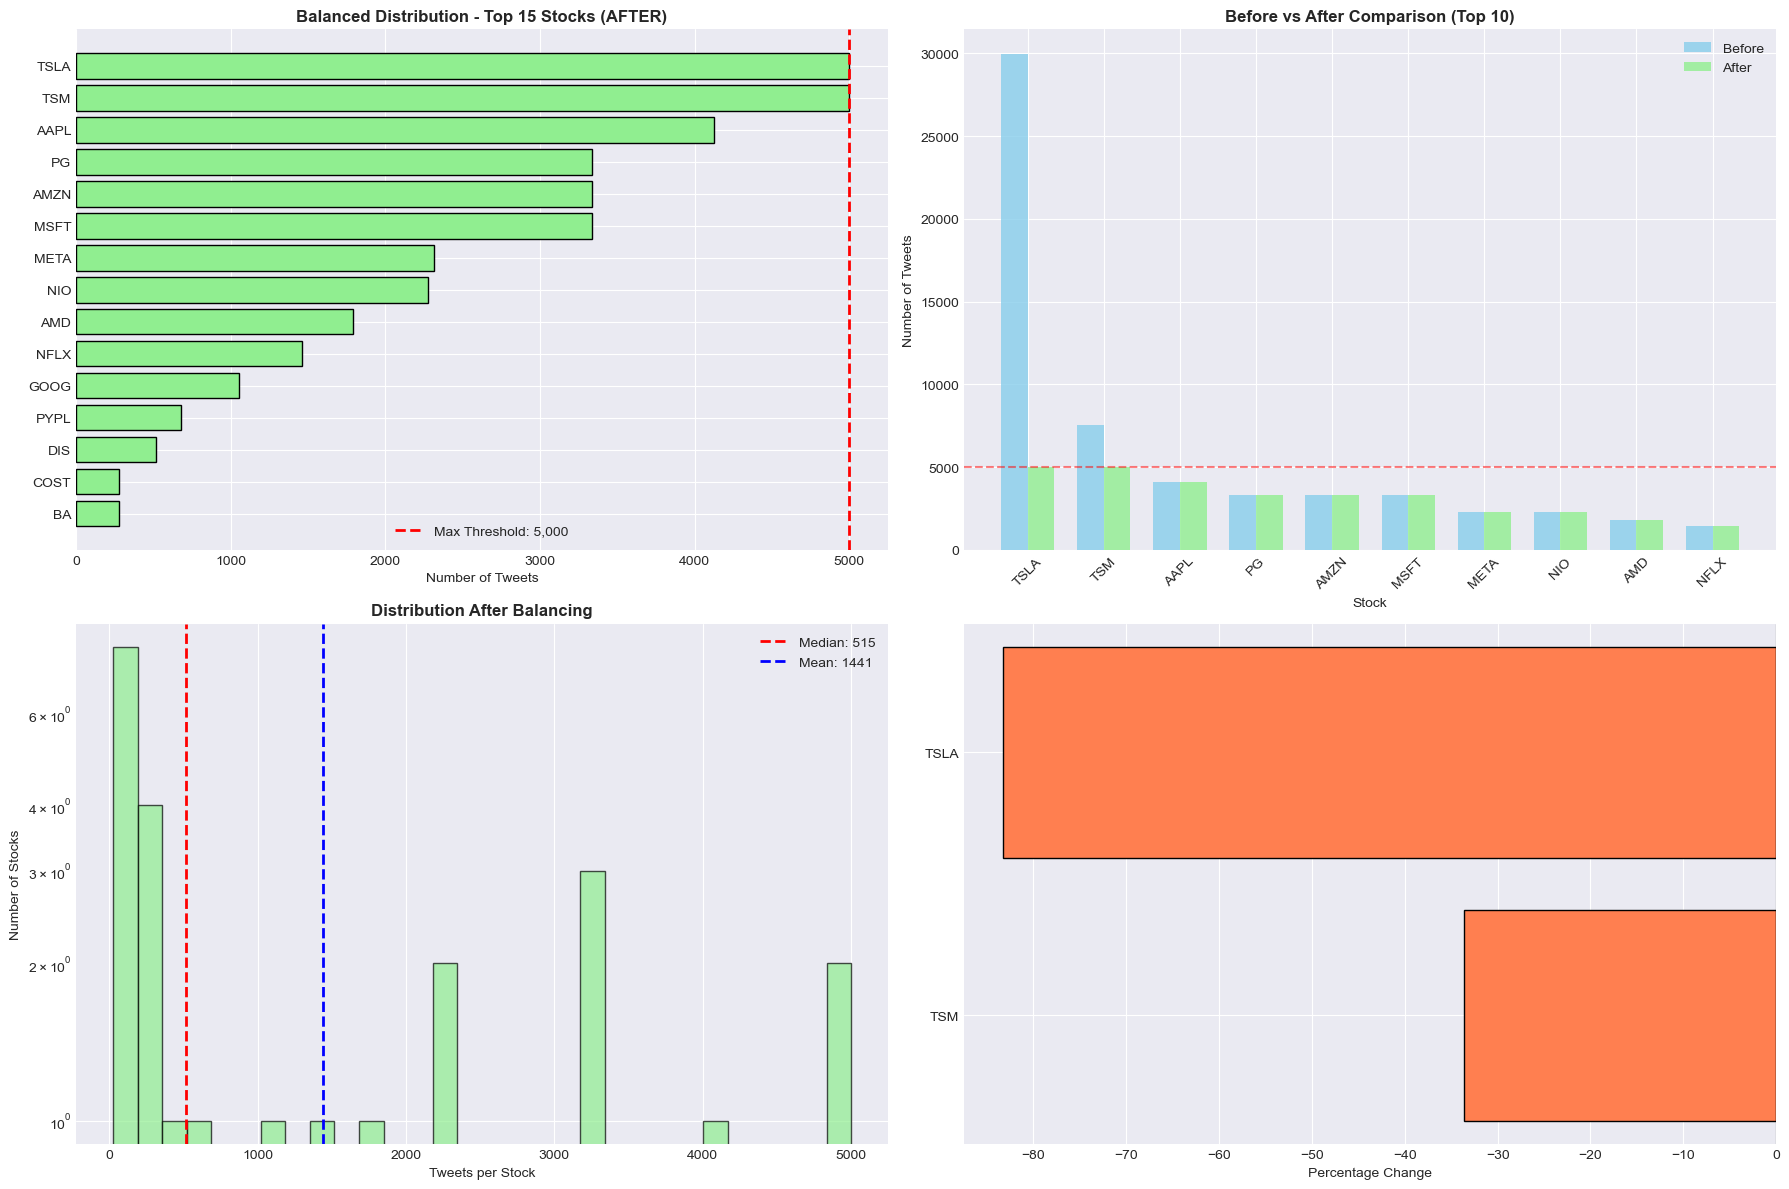

In [ ]:
# Visualize balanced distribution
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Top 15 stocks AFTER
top_15_after = stock_counts_after.head(15)
axes[0, 0].barh(range(len(top_15_after)), top_15_after.values, color='lightgreen', edgecolor='black')
axes[0, 0].set_yticks(range(len(top_15_after)))
axes[0, 0].set_yticklabels(top_15_after.index)
axes[0, 0].set_xlabel('Number of Tweets')
axes[0, 0].set_title('Balanced Distribution - Top 15 Stocks (AFTER)', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].axvline(MAX_TWEETS_PER_STOCK, color='red', linestyle='--', linewidth=2, label=f'Max Threshold: {MAX_TWEETS_PER_STOCK:,}')
axes[0, 0].legend()

# 2. Before vs After comparison (Top 10)
top_10_stocks = stock_counts_before.head(10).index
x = np.arange(len(top_10_stocks))
width = 0.35

before_vals = [stock_counts_before[stock] for stock in top_10_stocks]
after_vals = [stock_counts_after[stock] for stock in top_10_stocks]

axes[0, 1].bar(x - width/2, before_vals, width, label='Before', alpha=0.8, color='skyblue')
axes[0, 1].bar(x + width/2, after_vals, width, label='After', alpha=0.8, color='lightgreen')
axes[0, 1].set_xlabel('Stock')
axes[0, 1].set_ylabel('Number of Tweets')
axes[0, 1].set_title('Before vs After Comparison (Top 10)', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(top_10_stocks, rotation=45)
axes[0, 1].legend()
axes[0, 1].axhline(MAX_TWEETS_PER_STOCK, color='red', linestyle='--', alpha=0.5, label='Threshold')

# 3. Distribution histogram AFTER
axes[1, 0].hist(stock_counts_after.values, bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1, 0].axvline(stock_counts_after.median(), color='red', linestyle='--', 
               linewidth=2, label=f'Median: {stock_counts_after.median():.0f}')
axes[1, 0].axvline(stock_counts_after.mean(), color='blue', linestyle='--', 
               linewidth=2, label=f'Mean: {stock_counts_after.mean():.0f}')
axes[1, 0].set_xlabel('Tweets per Stock')
axes[1, 0].set_ylabel('Number of Stocks')
axes[1, 0].set_title('Distribution After Balancing', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].set_yscale('log')

# 4. Percentage change per stock
pct_changes = []
stocks_changed = []
for stock in stocks_to_downsample.index:
    before = stock_counts_before[stock]
    after = stock_counts_after[stock]
    pct_change = ((after - before) / before) * 100
    pct_changes.append(pct_change)
    stocks_changed.append(stock)

axes[1, 1].barh(range(len(stocks_changed)), pct_changes, color='coral', edgecolor='black')
axes[1, 1].set_yticks(range(len(stocks_changed)))
axes[1, 1].set_yticklabels(stocks_changed)
axes[1, 1].set_xlabel('Percentage Change')
axes[1, 1].set_title('Percentage Reduction per Downsampled Stock', fontsize=12, fontweight='bold')
axes[1, 1].axvline(0, color='black', linewidth=0.8)
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()


## 4. Save Balanced Dataset


In [30]:
# Save balanced dataset
output_path = 'data/processed/balanced_tweets_stock_data.csv'
balanced_df.to_csv(output_path, index=False)

